# SC4002 Assignment - Master Notebook (Part 0 & 1)

**Team 3 (Aaron & Javier)**

This notebook contains all the foundational code for Part 0 and Part 1. 

1.  **Part 0:** Sets up the environment, loads the `TREC` dataset, and splits it into 80/20 Train/Validation sets.
2.  **Part 1:** Builds the vocabulary, loads GloVe embeddings, analyzes OOV words, implements an OOV strategy, and generates the t-SNE plot.

**Deliverable:** This notebook will be shared with Team 1 (RNN) and Team 2 (CNN) so they can build their models on the *exact same data pipeline*.

Environment Setup (CRITICAL!)This assignment requires the legacy torchtext==0.4.0 library because the code snippets in the PDF (like data.Field and data.BucketIterator) were removed in newer versions.After testing, we've confirmed that torchtext==0.4.0 can work with modern PyTorch (2.x), but we must use a stable, modern Python version that also supports the spacy library.The most stable setup is to use Python 3.12
conda create -n nlp_project python=3.12

2. Activate the new environment
conda activate nlp_project

3. Install all required libraries
This will get modern torch (2.x)
pip install torch

4. Install the legacy torchtext
pip install torchtext==0.4.0

5. Install spacy and its English model
pip install spacy
python -m spacy download en_core_web_sm

6. Install all other libraries for the notebook
pip install numpy scikit-learn matplotlib jupyter ipykernel
After installing, select this nlp_project environment as your kernel in VS Code.

In [1]:
# === Section 1: Imports ===

# Core PyTorch and TorchText (Legacy) Imports
import torch
import torch.nn as nn
import torchtext
from torchtext import data, datasets
from torchtext.vocab import GloVe

# Helper libraries
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import random
import warnings

# --- Setup ---

# Suppress warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

print(f"PyTorch Version: {torch.__version__}")
print(f"TorchText Version: {torchtext.__version__}")

# Define the 6 topic labels for the TREC dataset
TREC_LABELS = {
    0: 'ABBR', # Abbreviation
    1: 'ENTY', # Entity
    2: 'DESC', # Description
    3: 'HUM',  # Human
    4: 'LOC',  # Location
    5: 'NUM'   # Numeric
}
LABEL_NAMES = list(TREC_LABELS.values())
print(f"Target Labels: {LABEL_NAMES}")

PyTorch Version: 2.9.0+cpu
TorchText Version: 0.4.0
Target Labels: ['ABBR', 'ENTY', 'DESC', 'HUM', 'LOC', 'NUM']


## Part 0: Dataset Preparation

Load the `TREC` dataset and split the provided `train_data` into an 80% training set and a 20% validation set.

In [2]:
# === Section 2: Part 0 - Load Data & Split (CORRECTED for torchtext==0.4.0) ===

# 1. Define the Fields as shown in the PDF
# This is the "old" 0.4.0 way of defining how to process text and labels.
TEXT = data.Field(tokenize='spacy', 
                  tokenizer_language='en_core_web_sm', 
                  lower=True, 
                  include_lengths=True)

LABEL = data.LabelField()

# 2. Load the dataset using datasets.TREC.splits
# This will look for manually downloaded 'TREC_train.txt' and 'TREC_test.txt'
# files in the '.data' folder if the automatic download fails.
try:
    train_data, test_data = datasets.TREC.splits(
        root='.data',
        text_field=TEXT, 
        label_field=LABEL, 
        fine_grained=False
    )
except Exception as e:
    print("Error loading dataset. ")
    print("Please manually download 'TREC_train.txt' and 'TREC_test.txt' from fast.ai")
    print("and place them in a folder named '.data' in your project directory.")
    print(e)

print(f"Successfully loaded {len(train_data)} training examples and {len(test_data)} test examples.")
print(f"Example data point: {vars(train_data.examples[0])}")

# 3. Split the training data into 80% Train and 20% Validation
# In torchtext 0.4.0, we can use the built-in .split() method
train_dataset, valid_dataset = train_data.split(
    split_ratio=0.8, 
    stratified=True, 
    strata_field='label', 
    random_state=random.seed(42)
)

print(f"---")
print(f"New training set size: {len(train_dataset)}")
print(f"New validation set size: {len(valid_dataset)}")
print(f"Test set size: {len(test_data)}")

# 4. Build the vocabulary (Answer Q1a)
# We build the vocab *only* from our new training set.
# We do NOT load vectors here; we'll do that manually to find OOVs.
print("\nBuilding vocabulary from training data...")
TEXT.build_vocab(train_dataset, min_freq=1) # min_freq=1 includes all words
LABEL.build_vocab(train_dataset)

print(f"(Answer Q1a) Vocabulary size: {len(TEXT.vocab)}")

Successfully loaded 5452 training examples and 500 test examples.
Example data point: {'text': ['how', 'did', 'serfdom', 'develop', 'in', 'and', 'then', 'leave', 'russia', '?'], 'label': 'DESC'}
---
New training set size: 4362
New validation set size: 1090
Test set size: 500

Building vocabulary from training data...
(Answer Q1a) Vocabulary size: 7529


## Part 1: Word Embeddings & Analysis

Now we will build the vocabulary *only* from our new `train_dataset` and analyze it against pre-trained embeddings.

In [3]:
# === Section 3: Part 1 (Q1b) OOV Analysis & (Q1c) OOV Strategy ===

# 1. Load the GloVe embeddings separately
print("Loading GloVe embeddings (glove.6B.300d)...")
glove = GloVe(name='6B', dim=300, cache='.vector_cache')
print("GloVe loaded.")

# 2. (Answer Q1b) Manually find all OOV words
# We iterate our vocab (TEXT.vocab) and check if the word exists
# in the GloVe vocabulary (glove.stoi)
oov_words = []
for word in TEXT.vocab.itos: # itos = index-to-string
    if word not in glove.stoi: # stoi = string-to-index
        oov_words.append(word)

print(f"\n--- (Answer Q1b) OOV Analysis ---")
print(f"Total OOV words: {len(oov_words)} out of {len(TEXT.vocab)} vocab words.")
print(f"This is the REAL OOV count.")
print(f"First 50 OOV words: {oov_words[1:51]}") # Skip <unk> token

# 3. (Answer Q1b) OOV words per topic
oov_by_topic = defaultdict(set)
token_counts_by_topic = defaultdict(Counter)

# We need to build the token counts for the t-SNE plot
for ex in train_dataset.examples:
    topic_name = ex.label
    tokens = ex.text
    token_counts_by_topic[topic_name].update(tokens)
    for token in tokens:
        if token in oov_words:
            oov_by_topic[topic_name].add(token)

print("\n(Answer Q1b) Unique OOV words per topic:")
for topic_name in sorted(token_counts_by_topic.keys()):
    print(f"  {topic_name}: {len(oov_by_topic[topic_name])}")

# 4. (Answer Q1c) OOV Strategy: Manually build the embedding matrix
print("\n--- (Answer Q1c) OOV Strategy ---")
print("Implementing OOV Strategy: Building embedding matrix...")

embedding_dim = 300
embedding_matrix = torch.zeros((len(TEXT.vocab), embedding_dim))

oov_init_count = 0
for i, word in enumerate(TEXT.vocab.itos):
    if word in glove.stoi:
        # Word is in GloVe, copy the vector
        embedding_matrix[i] = glove.get_vecs_by_tokens(word)
    else:
        # Word is OOV, initialize with small random values
        # We skip the <unk> token (index 0) which stays zeros
        if i != 0: 
            embedding_matrix[i] = torch.randn(embedding_dim) * 0.1 # Small random noise
            oov_init_count += 1

print(f"Embedding matrix created with shape: {embedding_matrix.shape}")
print(f"Initialized {oov_init_count} OOV word vectors randomly.")

# 5. Finally, tell our TEXT.vocab to use this new matrix
# This is the correct, debugged line.
TEXT.vocab.vectors = embedding_matrix

print("OOV Strategy Implemented. The `TEXT.vocab.vectors` matrix is now ready.")

Loading GloVe embeddings (glove.6B.300d)...
GloVe loaded.

--- (Answer Q1b) OOV Analysis ---
Total OOV words: 192 out of 7529 vocab words.
This is the REAL OOV count.
First 50 OOV words: ['<pad>', '..', 'crokinole', 'daminozide', 'dextropropoxyphen', 'indiglo', 'napsylate', 'vbp', '-lantern', '.com', '.dbf', '.tbk', '000th', '10-', '12601', '187s', '2th', '36893', '37803', '45mhz', '5943', '7847', '8/28/1941', '86ed', '9971', 'a_tisket', 'adventours', 'aeul', 'affiant', 'aim-54c', 'amazonis', 'amendements', 'amezaiku', 'antidisestablishmentarianism', 'arometherapy', 'auerstadt', 'auh2o', 'b.y.o.b.', 'ballcock', 'barkis', 'baseemen', 'basophobic', 'bebrenia', 'bellworts', 'bergeres', 'bicornate', 'breony', 'brontosauruses', 'burnford', 'capricorns']

(Answer Q1b) Unique OOV words per topic:
  ABBR: 5
  DESC: 70
  ENTY: 47
  HUM: 36
  LOC: 14
  NUM: 21

--- (Answer Q1c) OOV Strategy ---
Implementing OOV Strategy: Building embedding matrix...
Embedding matrix created with shape: torch.Siz

### (Answer Q1c) OOV Strategy Proposal

**Our strategy is to create a custom embedding matrix.**

1.  We will initialize a matrix of zeros with shape `(vocab_size, embedding_dim)`.
2.  We iterate through our vocabulary. If a word **is** in the pre-trained GloVe vectors, we copy the GloVe vector into our matrix at that word's index.
3.  If a word **is not** in GloVe (it's an OOV word), we will initialize its vector with small random values (e.g., from `torch.randn * 0.1`).

Finally, we will load this matrix into `torch.nn.Embedding`. This allows the model to use the pre-trained vectors for known words while still being able to *learn* meaningful representations for the OOV words during training.

Finding 20 most frequent words per topic (excluding stopwords)...
Total words to plot: 120
Running t-SNE... (This can take a moment)
t-SNE complete.


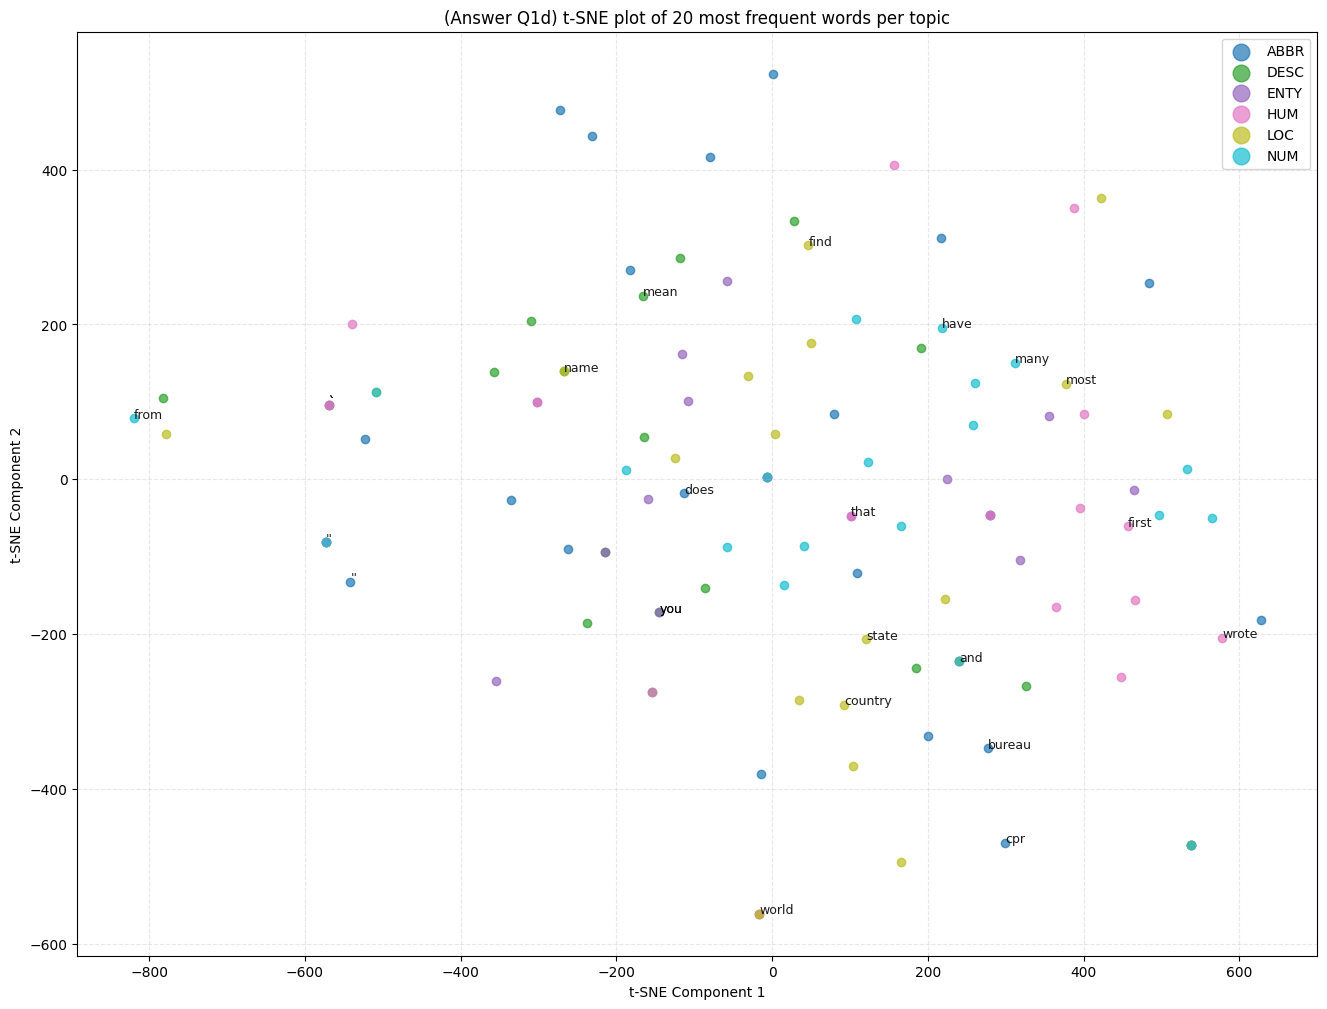

In [4]:
# === Section 4: Part 1 (Q1d) - t-SNE Plot ===

# Define a set of common English stopwords to exclude from the plot
STOP_WORDS = set([
    "'s", "'", "'m", "'re", "'ve", "'d", "'ll", "n't", "a", "an", "the", "in", "on", 
    "at", "for", "to", "of", "by", "with", "is", "are", "was", "were", "what", 
    "which", "who", "when", "where", "why", "how", "what's", "?", ".", ",", "!"
])

words_to_plot = []
labels_for_plot = []
word_vectors = []

print("Finding 20 most frequent words per topic (excluding stopwords)...")

# Use the LABEL_NAMES list we defined to keep order
for topic_name in LABEL_NAMES:
    count = 0
    # Get the most common words for this topic
    for word, freq in token_counts_by_topic[topic_name].most_common():
        if count >= 20:
            break
        # Check if the word is in our vocab, not a stopword, and not an OOV
        if word in TEXT.vocab.stoi and word not in STOP_WORDS and word not in oov_words:
            words_to_plot.append(word)
            labels_for_plot.append(topic_name)
            
            # Get the vector from our *final* matrix
            word_index = TEXT.vocab.stoi[word]
            word_vectors.append(TEXT.vocab.vectors[word_index].numpy())
            count += 1

print(f"Total words to plot: {len(words_to_plot)}")

# Convert to numpy array for sklearn
word_vectors_np = np.array(word_vectors)

# --- Run t-SNE ---
print("Running t-SNE... (This can take a moment)")
# Set learning_rate explicitly to avoid issues with old sklearn versions
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='pca', learning_rate=200) 
vectors_2d = tsne.fit_transform(word_vectors_np)
print("t-SNE complete.")

# --- Plot t-SNE ---
plt.figure(figsize=(16, 12))
unique_labels = sorted(list(set(labels_for_plot)))
colors = plt.cm.get_cmap('tab10', len(unique_labels))

for i, label in enumerate(unique_labels):
    # Find indices for this label
    indices = [j for j, l in enumerate(labels_for_plot) if l == label]
    plt.scatter(vectors_2d[indices, 0], vectors_2d[indices, 1], color=colors(i), label=label, alpha=0.7)

# Annotate some words
for i in range(len(words_to_plot)):
    # Annotate every 5th word to avoid clutter
    if i % 5 == 0:
        plt.annotate(words_to_plot[i], (vectors_2d[i, 0], vectors_2d[i, 1]), alpha=0.9, fontsize=9)

plt.legend(markerscale=2)
plt.title("(Answer Q1d) t-SNE plot of 20 most frequent words per topic")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

In [5]:
# === Section 5: Helper Functions for All Teams (The 0.4.0 Way) ===

# 1. Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Create the DataLoaders (Iterators)
# In torchtext 0.4.0, the correct way to batch data is with a BucketIterator.
# This automatically handles padding and sorting by length.
BATCH_SIZE = 64

# This is the corrected version that uses the right variable names.
# 'train_dataset' and 'valid_dataset' come from train_data.split()
# 'test_data' is the original test set loaded from the file.
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_dataset, valid_dataset, test_data),  # <-- This is the CORRECTED line
    batch_size=BATCH_SIZE,
    sort_key=lambda x: len(x.text), # Sort by sequence length (good for RNNs)
    sort_within_batch=True,
    device=device
)
print("Successfully created data iterators (BucketIterator).")


# 3. Function to create the final embedding layer
def create_embedding_layer(freeze=False):
    # We use the 'TEXT.vocab.vectors' matrix we manually built
    embedding_layer = nn.Embedding.from_pretrained(
        TEXT.vocab.vectors, 
        freeze=freeze
    )
    # We also need to get the padding token index from the vocab
    # This tells the model to ignore padding tokens during training
    padding_idx = TEXT.vocab.stoi[TEXT.pad_token]
    embedding_layer.padding_idx = padding_idx
    return embedding_layer

print("\n--- MASTER NOTEBOOK COMPLETE ---")
print("All data is loaded and helper functions are defined.")
print("The following are now ready for all teams:")
print(f"  - train_iterator (Batches: {len(train_iterator)})")
print(f"  - valid_iterator (Batches: {len(valid_iterator)})")
print(f"  - test_iterator (Batches: {len(test_iterator)})")
print("  - create_embedding_layer() (function)")
print(f"  - LABEL.vocab (for output dims: {len(LABEL.vocab)})")
print(f"  - TEXT.vocab (for input dims: {len(TEXT.vocab)})")

Using device: cpu
Successfully created data iterators (BucketIterator).

--- MASTER NOTEBOOK COMPLETE ---
All data is loaded and helper functions are defined.
The following are now ready for all teams:
  - train_iterator (Batches: 69)
  - valid_iterator (Batches: 18)
  - test_iterator (Batches: 8)
  - create_embedding_layer() (function)
  - LABEL.vocab (for output dims: 6)
  - TEXT.vocab (for input dims: 7529)
